## First iteration of modeling, going through several different classification algorithms. Of these, Gradient Boosted Classifier using unscaled data worked the best. 
## For reference/example only.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import datetime as datetime
import cPickle as pickle
%matplotlib notebook
plt.style.use('ggplot')

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from sklearn.grid_search import GridSearchCV

### read in data

In [8]:
masterdf_rrt = pickle.load(open('RRT_modeling_table_13hr_raw_fromv7_rev1.p', 'rb'))
# X_rrt = pickle.load(open('XRRT_modeling_table_13hr_processed_wnan_fromv5.p', 'rb'))
masterdf_nonrrt = pickle.load(open('NonRRT_modeling_table_13hr_raw_fromv7_rev1.p', 'rb'))
# X_notrrt = pickle.load(open('XnonRRT_modeling_table_13hr_processed_wnan_v5.p', 'rb'))

In [9]:
col_use = ['on_iv', 'bu-nal',
           'age', 'sex', 'obese', 'smoker', 'prev_rrt',
           'DBP_mean', 'DBP_recent', # take the mean of all the measurements & the most recently observed point
            'SBP_mean', 'SBP_recent',
            'MAP_mean', 'MAP_recent', # mean arterial pressure
             'temp_mean', 'temp_recent',# temperature
             'SPO2_mean', 'SPO2_recent',
            'RR_mean', 'RR_recent', # respiratory rate
            'pulse_mean', 'pulse_recent',
           'anticoagulants', 'narcotics', 'narc-ans', #narcotic analgesics
            'antipsychotics', 'chemo'
]

colsfornan = ['DBP_mean', 'DBP_recent', # take the mean of all the measurements & the most recently observed point
            'SBP_mean', 'SBP_recent',
            'MAP_mean', 'MAP_recent', # mean arterial pressure
             'temp_mean', 'temp_recent',# temperature
             'SPO2_mean', 'SPO2_recent',
            'RR_mean', 'RR_recent', # respiratory rate
            'pulse_mean', 'pulse_recent']


In [10]:
# take out: rrt_ce_id, encntr_id, event_end_dt_tm, timestart, timeend,
# RASS score, GCS score, HR, CO2, O2
X_rrt = masterdf_rrt[col_use]

# if 'obese' is Nan, then set the patient to be not obese.
obesenanmask = np.where(pd.isnull(X_rrt['obese']))[0]
X_rrt.loc[obesenanmask, 'obese'] = 0

# Write out rows that are not all 0/NaNs across. (if all nans, remove this sample)
X_rrt = X_rrt.loc[np.where(X_rrt.ix[:, colsfornan].sum(axis=1, skipna=True)!=0)[0]]

#reset index
X_rrt = X_rrt.reset_index(drop=True)

/opt/cloudera/parcels/Anaconda-4.0.0/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
# take out: encntr_id, not_rrt_time, timestart, timeend,
#  RASS score, GCS score, HR, CO2, O2
X_notrrt = masterdf_nonrrt[col_use]

# if 'obese' is Nan, then set the patient to be not obese.
obesenanmask = np.where(pd.isnull(X_notrrt['obese']))[0]
X_notrrt.loc[obesenanmask, 'obese'] = 0

# Write out rows that are NOT all 0/NaNs across.
X_notrrt = X_notrrt.iloc[np.where(X_notrrt.ix[:, colsfornan].sum(axis=1, skipna=True)!=0)[0]]

#reset index
X_notrrt = X_notrrt.reset_index(drop=True)


In [12]:
# make sure to reset index if haven't previously -- I did not run this before saving processed .p files
X_notrrt = X_notrrt.reset_index(drop=True)
X_rrt = X_rrt.reset_index(drop=True)


# additional for non-rrt: drop samples with lots of NaNs since we have plenty of samples
# DROP THE ROWS WHERE PULSE IS NAN
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['pulse_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

# Do a similar thing for all rows with significant nans:
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['RR_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['MAP_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['temp_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['SPO2_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

# add labels to indicate positive or negative class
X_rrt['label'] = 1
X_notrrt['label'] = 0

# Combine the tables
XY = pd.concat([X_rrt, X_notrrt])
XY = XY.reset_index(drop=True)
y = XY.pop('label')
X = XY

# Fill nans with mean of columns
X = X.fillna(X.mean())

# map genders to 1/0
X['is_male'] = X['sex'].map({'M': 1, 'F': 0})
X.pop('sex')

0       M
1       F
2       F
3       M
4       F
5       F
6       F
7       M
8       F
9       F
10      M
11      F
12      M
13      M
14      M
15      M
16      F
17      M
18      F
19      F
20      F
21      F
22      F
23      M
24      M
25      M
26      F
27      F
28      F
29      M
       ..
3941    F
3942    F
3943    M
3944    M
3945    F
3946    M
3947    F
3948    F
3949    M
3950    M
3951    M
3952    F
3953    F
3954    F
3955    F
3956    F
3957    M
3958    F
3959    M
3960    F
3961    M
3962    M
3963    F
3964    F
3965    F
3966    M
3967    F
3968    M
3969    M
3970    F
Name: sex, dtype: object

In [13]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
on_iv,3971.0,0.771342,0.420021,0.000000,1.000000,1.000000,1.000000,1.000000
bu-nal,3971.0,0.018131,0.133444,0.000000,0.000000,0.000000,0.000000,1.000000
age,3971.0,65.045832,17.595523,14.000000,55.000000,67.000000,78.000000,105.000000
obese,3971.0,0.240242,0.427284,0.000000,0.000000,0.000000,0.000000,1.000000
smoker,3971.0,0.111559,0.314863,0.000000,0.000000,0.000000,0.000000,1.000000
prev_rrt,3971.0,0.079577,0.270671,0.000000,0.000000,0.000000,0.000000,1.000000
DBP_mean,3971.0,71.503803,10.483884,37.916667,64.125000,71.090909,78.500000,122.312500
DBP_recent,3971.0,71.540091,12.278271,9.000000,63.000000,71.000000,79.000000,147.000000
SBP_mean,3971.0,127.354561,21.216642,61.200000,112.183333,125.333333,141.645833,207.388889
SBP_recent,3971.0,126.754726,23.739414,1.000000,110.000000,125.000000,143.000000,228.000000


In [14]:
y.describe().T

count    3971.000000
mean        0.492319
std         0.500004
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

# Modeling portion

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
len(X_train)

2779

In [17]:
def score_printout(X_test, y_test, fittedModel):
    print "AUC-ROC Score of model: ", roc_auc_score(y_test, fittedModel.predict_proba(X_test)[:,1])
    print "Precision Score of model: ", precision_score(y_test, fittedModel.predict(X_test))
    print "Recall Score of model: ", recall_score(y_test, fittedModel.predict(X_test))

## Logistic Regression

In [ ]:
lrCV = LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)
lrCV.fit(X, y)
lrCV.scores_

In [4]:
# Try different solver
lrCV = LogisticRegressionCV(Cs=5, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)
lrCV.fit(X_train, y_train)
lrCV.scores_

NameError: name 'X_train' is not defined

In [ ]:
lrCV.intercept_

In [ ]:
lrCV.n_iter_

In [183]:
lrCV.Cs_

array([  1.00000000e-04,   1.00000000e-02,   1.00000000e+00,
         1.00000000e+02,   1.00000000e+04])

In [185]:
score_printout(X_test, y_test, lrCV)

AUC-ROC Score of model:  0.828096382784
Precision Score of model:  0.824949698189
Recall Score of model:  0.657051282051


In [186]:
confusion_matrix(y_test, lrCV.predict(X_test))

array([[529,  87],
       [214, 410]])

### compare to traditional LR...

In [ ]:
lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lr.fit(X_train, y_train)

In [208]:
score_printout(X_test, y_test, lr)

AUC-ROC Score of model:  0.827073967699
Precision Score of model:  0.824949698189
Recall Score of model:  0.657051282051


In [229]:
print classification_report(y_test, lr.predict(X_test))

             precision    recall  f1-score   support

          0       0.71      0.86      0.78       616
          1       0.82      0.66      0.73       624

avg / total       0.77      0.76      0.75      1240



In [209]:
confusion_matrix(y_test, lr.predict(X_test))

array([[529,  87],
       [214, 410]])

In [210]:
lr.decision_function(X_test)

array([ 4.99801144,  3.04441914, -1.12785541, ..., -0.01937631,
       -0.53171913, -2.32849802])

In [211]:
lr.coef_

array([[ -7.78274140e-02,   1.45474292e+00,   1.53146264e-02,
         -1.19863982e-01,   3.93525328e+00,   4.22303070e+00,
         -5.55736237e-02,   3.05828349e-03,   8.48571399e-03,
         -1.24948645e-02,   3.26719977e-02,   1.46794849e-03,
          8.73844838e-02,  -2.48869699e-01,  -3.74780771e-02,
          2.53655628e-02,   1.12410413e-01,   1.14747421e-01,
          2.48957578e-02,   1.45721490e-02,   0.00000000e+00,
         -6.36144355e-02,  -3.57952120e-01,   4.86055522e-01,
          2.54704475e-01,   4.25141980e-02]])

In [212]:
lr.intercept_

array([-0.40894054])

### LR & LRCV returned essentially the same results!
### Let's rerun LR with scaled data. And then calculate 

In [13]:
Xscaled = StandardScaler().fit_transform(X)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xscaled, y, test_size=0.3)

In [ ]:
lrs = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lrs.fit(Xs_train, ys_train)

In [236]:
score_printout(Xs_test, ys_test, lrs)
print classification_report(ys_test, lrs.predict(Xs_test))
confusion_matrix(ys_test, lrs.predict(Xs_test))

AUC-ROC Score of model:  0.83332422423
Precision Score of model:  0.828810020877
Recall Score of model:  0.654036243822
             precision    recall  f1-score   support

          0       0.72      0.87      0.79       633
          1       0.83      0.65      0.73       607

avg / total       0.78      0.76      0.76      1240



array([[551,  82],
       [210, 397]])

## Scaled version performs (slightly) better

### Random Forest

In [16]:
rfs = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfs.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, rfs)
print classification_report(ys_test, rfs.predict(Xs_test))
confusion_matrix(ys_test, rfs.predict(Xs_test))

AUC-ROC Score of model:  0.803383846353
Precision Score of model:  0.76
Recall Score of model:  0.657439446367
             precision    recall  f1-score   support

          0       0.71      0.80      0.76       614
          1       0.76      0.66      0.71       578

avg / total       0.74      0.73      0.73      1192



array([[494, 120],
       [198, 380]])

In [17]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(X_train, y_train)
score_printout(X_test, y_test, rf)
print classification_report(y_test, rf.predict(X_test))
confusion_matrix(y_test, rf.predict(X_test))
# scaled & unscaled random forest looks very similar.

AUC-ROC Score of model:  0.796389492708
Precision Score of model:  0.770961145194
Recall Score of model:  0.657940663176
             precision    recall  f1-score   support

          0       0.72      0.82      0.77       619
          1       0.77      0.66      0.71       573

avg / total       0.75      0.74      0.74      1192



array([[507, 112],
       [196, 377]])

In [18]:
rfs = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfs.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, rfs)
print classification_report(ys_test, rfs.predict(Xs_test))
confusion_matrix(ys_test, rfs.predict(Xs_test))

AUC-ROC Score of model:  0.806310088703
Precision Score of model:  0.7920997921
Recall Score of model:  0.659169550173
             precision    recall  f1-score   support

          0       0.72      0.84      0.78       614
          1       0.79      0.66      0.72       578

avg / total       0.76      0.75      0.75      1192



array([[514, 100],
       [197, 381]])

In [19]:
# Increase # estimators
# Note, turning oob score on makes the result worse...
rfs = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfs.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, rfs)
print classification_report(ys_test, rfs.predict(Xs_test))
confusion_matrix(ys_test, rfs.predict(Xs_test))

AUC-ROC Score of model:  0.835487979442
Precision Score of model:  0.809523809524
Recall Score of model:  0.705882352941
             precision    recall  f1-score   support

          0       0.75      0.84      0.80       614
          1       0.81      0.71      0.75       578

avg / total       0.78      0.78      0.78      1192



array([[518,  96],
       [170, 408]])

### SVM (kernel: sigmoid does not work, rbf appears best)

In [247]:
svms =  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svms.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, svms)
print classification_report(ys_test, svms.predict(Xs_test))
confusion_matrix(ys_test, svms.predict(Xs_test))

 AUC-ROC Score of model:  0.848013304497
Precision Score of model:  0.867102396514
Recall Score of model:  0.65568369028
             precision    recall  f1-score   support

          0       0.73      0.90      0.81       633
          1       0.87      0.66      0.75       607

avg / total       0.80      0.78      0.78      1240



array([[572,  61],
       [209, 398]])

In [248]:
svms =  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svms.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, svms)
print classification_report(ys_test, svms.predict(Xs_test))
confusion_matrix(ys_test, svms.predict(Xs_test))

AUC-ROC Score of model:  0.813532744625
Precision Score of model:  0.905604719764
Recall Score of model:  0.505766062603
             precision    recall  f1-score   support

          0       0.67      0.95      0.78       633
          1       0.91      0.51      0.65       607

avg / total       0.78      0.73      0.72      1240



array([[601,  32],
       [300, 307]])

In [250]:
svms =  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svms.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, svms)
print classification_report(ys_test, svms.predict(Xs_test))
confusion_matrix(ys_test, svms.predict(Xs_test))

AUC-ROC Score of model:  0.831204405683
Precision Score of model:  0.857466063348
Recall Score of model:  0.624382207578
             precision    recall  f1-score   support

          0       0.71      0.90      0.80       633
          1       0.86      0.62      0.72       607

avg / total       0.78      0.77      0.76      1240



array([[570,  63],
       [228, 379]])

In [252]:
svms =  SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svms.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, svms)
print classification_report(ys_test, svms.predict(Xs_test))
confusion_matrix(ys_test, svms.predict(Xs_test))

AUC-ROC Score of model:  0.800718838407
Precision Score of model:  0.746453900709
Recall Score of model:  0.693574958814
             precision    recall  f1-score   support

          0       0.72      0.77      0.75       633
          1       0.75      0.69      0.72       607

avg / total       0.74      0.73      0.73      1240



array([[490, 143],
       [186, 421]])

### LDA

In [282]:
ldas = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
ldas.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, ldas)
print classification_report(ys_test, ldas.predict(Xs_test))
confusion_matrix(ys_test, ldas.predict(Xs_test))

AUC-ROC Score of model:  0.831640341357
Precision Score of model:  0.852607709751
Recall Score of model:  0.619439868204
             precision    recall  f1-score   support

          0       0.71      0.90      0.79       633
          1       0.85      0.62      0.72       607

avg / total       0.78      0.76      0.76      1240



array([[568,  65],
       [231, 376]])

In [286]:
ldas = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='eigen', store_covariance=False, tol=0.0001)
ldas.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, ldas)
print classification_report(ys_test, ldas.predict(Xs_test))
confusion_matrix(ys_test, ldas.predict(Xs_test))

AUC-ROC Score of model:  0.831838139036
Precision Score of model:  0.859122401848
Recall Score of model:  0.612850082372
             precision    recall  f1-score   support

          0       0.71      0.90      0.79       633
          1       0.86      0.61      0.72       607

avg / total       0.78      0.76      0.76      1240



array([[572,  61],
       [235, 372]])

### Gradient Boosting (with partial dependence plots)
(no partial dependence plots for rf?)

In [302]:
gbcs = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)
gbcs.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, gbcs)
print classification_report(ys_test, gbcs.predict(Xs_test))
confusion_matrix(ys_test, gbcs.predict(Xs_test))

AUC-ROC Score of model:  0.86412080233
Precision Score of model:  0.844311377246
Recall Score of model:  0.69686985173
             precision    recall  f1-score   support

          0       0.75      0.88      0.81       633
          1       0.84      0.70      0.76       607

avg / total       0.80      0.79      0.79      1240



array([[555,  78],
       [184, 423]])

In [309]:
# changed subsampling: Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
gbcs = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=0.75, verbose=0,
              warm_start=False)
gbcs.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, gbcs)
print classification_report(ys_test, gbcs.predict(Xs_test))
confusion_matrix(ys_test, gbcs.predict(Xs_test))

AUC-ROC Score of model:  0.873073749906
Precision Score of model:  0.848249027237
Recall Score of model:  0.718286655684
             precision    recall  f1-score   support

          0       0.76      0.88      0.82       633
          1       0.85      0.72      0.78       607

avg / total       0.81      0.80      0.80      1240



array([[555,  78],
       [171, 436]])

In [320]:
# tried changing loss to exponential --> worse.
# change max features to sqrt --> worse.
# upped min_samples_split, from 2 to 3, improved. (other values did not cause improvement)

gbcs = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=0.75, verbose=0,
              warm_start=False)
gbcs.fit(Xs_train, ys_train)
score_printout(Xs_test, ys_test, gbcs)
print classification_report(ys_test, gbcs.predict(Xs_test))
confusion_matrix(ys_test, gbcs.predict(Xs_test))

AUC-ROC Score of model:  0.873123199325
Precision Score of model:  0.851851851852
Recall Score of model:  0.719934102142
             precision    recall  f1-score   support

          0       0.77      0.88      0.82       633
          1       0.85      0.72      0.78       607

avg / total       0.81      0.80      0.80      1240



array([[557,  76],
       [170, 437]])

In [326]:
for i, n in enumerate(X.columns.get_values()):
    print i, n

0 on_iv
1 bu-nal
2 age
3 obese
4 smoker
5 prev_rrt
6 DBP_mean
7 DBP_recent
8 SBP_mean
9 SBP_recent
10 MAP_mean
11 MAP_recent
12 temp_mean
13 temp_recent
14 SPO2_mean
15 SPO2_recent
16 RR_mean
17 RR_recent
18 pulse_mean
19 pulse_recent
20 anticoagulants
21 narcotics
22 narc-ans
23 antipsychotics
24 chemo
25 is_male


<IPython.core.display.Javascript object>


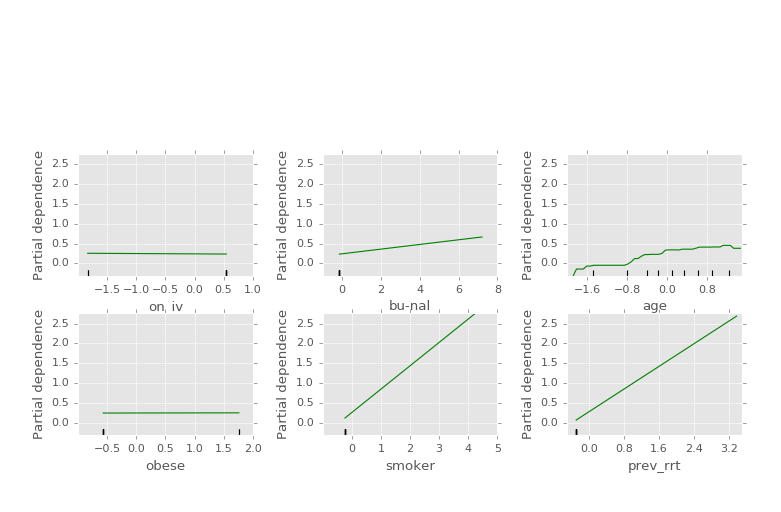

In [337]:
fig, axs = plot_partial_dependence(gbcs, Xs_train, range(0, 6, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)

<IPython.core.display.Javascript object>


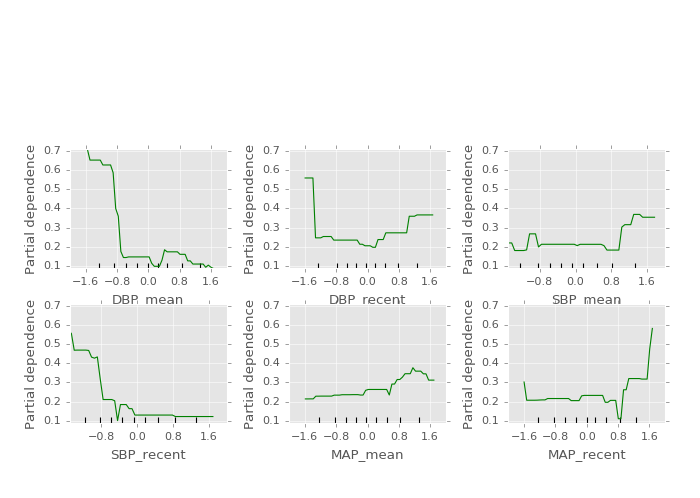

In [338]:
fig, axs = plot_partial_dependence(gbcs, Xs_train, range(6, 12, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)

<IPython.core.display.Javascript object>


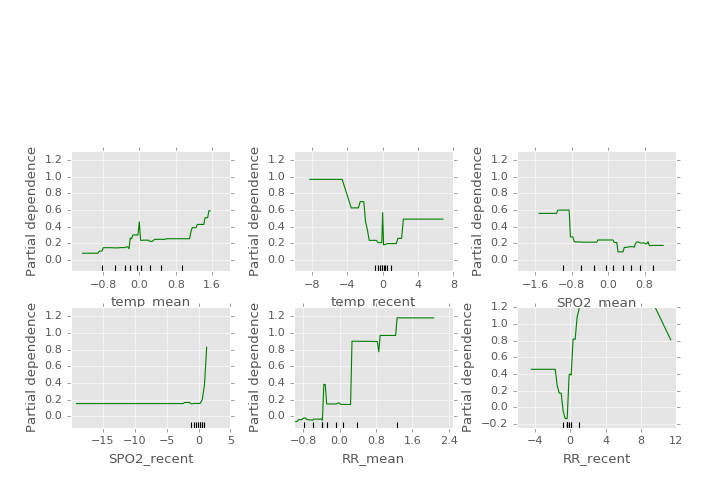

In [340]:
fig, axs = plot_partial_dependence(gbcs, Xs_train, range(12, 18, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=100)

<IPython.core.display.Javascript object>


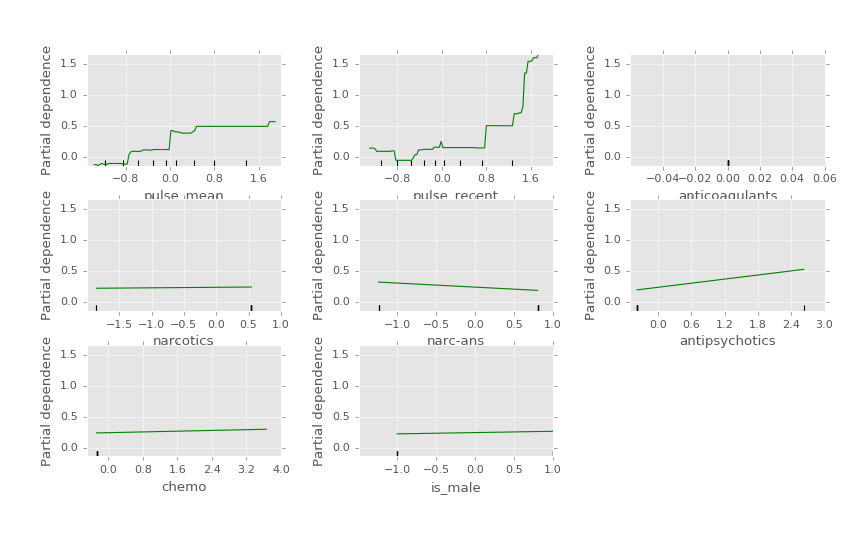

In [343]:
fig, axs = plot_partial_dependence(gbcs, Xs_train, range(18, 26, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=100)
plt.subplots_adjust(top=0.9)

In [344]:
# GBC without scaling works better than GBC with. Hmm.
gbc = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=0.75, verbose=0,
              warm_start=False)
gbc.fit(X_train, y_train)
score_printout(X_test, y_test, gbc)
print classification_report(y_test, gbc.predict(X_test))
confusion_matrix(y_test, gbc.predict(X_test))

AUC-ROC Score of model:  0.874849109224
Precision Score of model:  0.852611940299
Recall Score of model:  0.732371794872
             precision    recall  f1-score   support

          0       0.76      0.87      0.81       616
          1       0.85      0.73      0.79       624

avg / total       0.81      0.80      0.80      1240



array([[537,  79],
       [167, 457]])

<IPython.core.display.Javascript object>


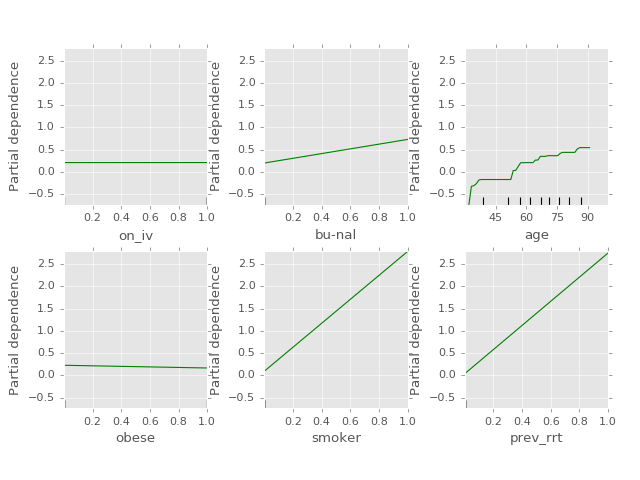

In [345]:
fig, axs = plot_partial_dependence(gbc, X_train, range(0, 6, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


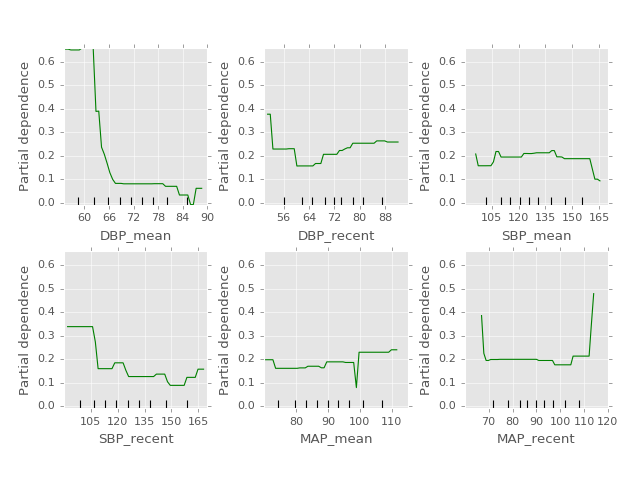

In [346]:
fig, axs = plot_partial_dependence(gbc, X_train, range(6, 12, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


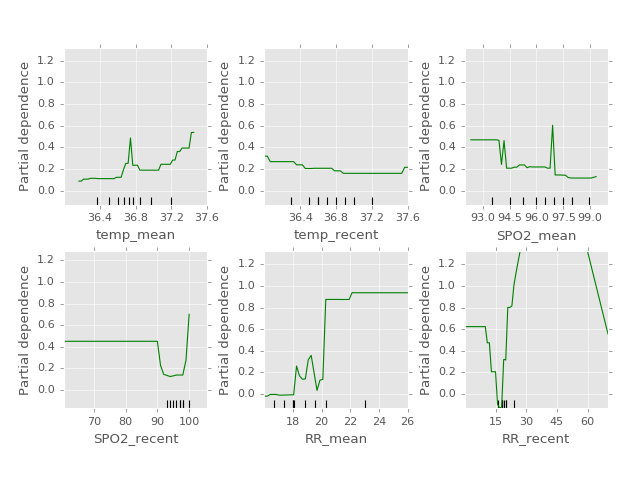

In [347]:
fig, axs = plot_partial_dependence(gbc, X_train, range(12, 18, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


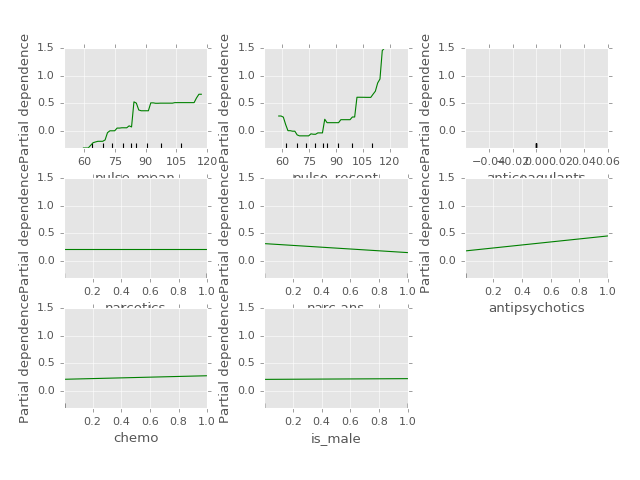

In [350]:
fig, axs = plot_partial_dependence(gbc, X_train, range(18, 26, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

In [17]:
gbcRankedFeatures = sorted(zip(X.columns, gbc.feature_importances_), 
                          key=lambda pair: pair[1], 
                          reverse=True)

def make_feature_importance_plot(featuresAndImportances, numFeatures):
    topN = featuresAndImportances[:numFeatures]
    labels = [pair[0] for pair in topN]
    values = [pair[1] for pair in topN]
    ind = np.arange(len(values))
    width = 0.35   
    plt.bar(range(numFeatures), values, width=0.8)
    ax = plt.subplot(111)
    ax.set_xticks(ind+width)
    ax.set_xticklabels(labels, rotation=60, size=12)
    plt.xlabel('Feature', size=20)
    plt.ylabel('Importance', size=20)
    plt.show()
  

NameError: name 'gbc' is not defined

<IPython.core.display.Javascript object>


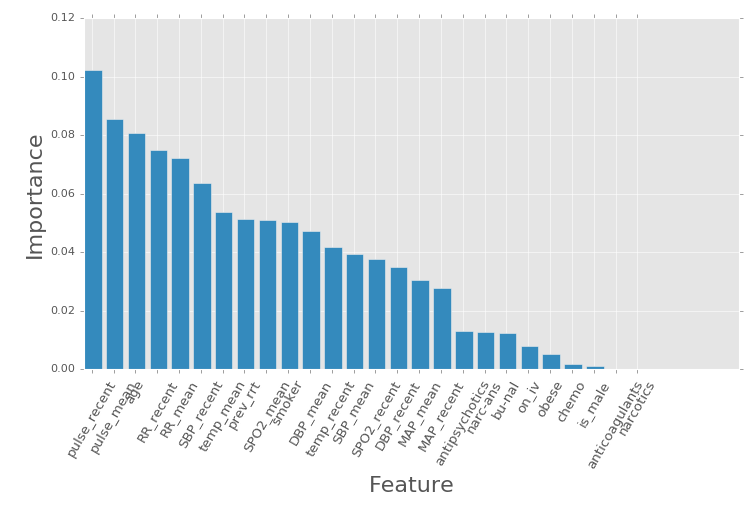

In [359]:
plt.figure()
make_feature_importance_plot(gbcRankedFeatures, 26)
plt.tight_layout()

In [351]:
gbc.feature_importances_

array([ 0.00784694,  0.01226492,  0.0808782 ,  0.0052503 ,  0.05036739,
        0.05139899,  0.04740138,  0.03496752,  0.03942804,  0.06361646,
        0.03057374,  0.02770252,  0.05387847,  0.04175406,  0.0511388 ,
        0.0377339 ,  0.07214211,  0.07498593,  0.08563654,  0.10242295,
        0.        ,  0.        ,  0.01269061,  0.01313425,  0.00170617,
        0.00107982])

## Grid search for best GBC

In [ ]:
# # GBC without scaling works better than GBC with. Hmm.
# gbc = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
#               max_depth=3, max_features=None, max_leaf_nodes=None,
#               min_samples_leaf=1, min_samples_split=3,
#               min_weight_fraction_leaf=0.0, n_estimators=100,
#               presort='auto', random_state=1, subsample=0.75, verbose=0,
#               warm_start=False)
# gbc.fit(X_train, y_train)
# score_printout(X_test, y_test, gbc)
# print classification_report(y_test, gbc.predict(X_test))
# confusion_matrix(y_test, gbc.predict(X_test))

In [413]:
paramGrid = {'n_estimators': [100, 200, 300],
             'learning_rate': [0.1, 0.5, 0.75, 0.2],
             'max_depth': [3, 4, 5, 6],
             'min_samples_leaf': [1, 2],
             'subsample': [0.75],
             'loss': ['deviance'],
             'max_features': [None, 'auto']
            }

gs = GridSearchCV(GradientBoostingClassifier(), 
                  param_grid=paramGrid, 
                  scoring='roc_auc', 
                  n_jobs=-1, 
                  cv=5, 
                  verbose=10)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_e

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3, score=0.854851 -   0.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.838026 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.848049 -   0.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.877461 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.856726 -   0.5s


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.838540 -   0.9s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.880294 -   0.9s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.859165 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.876256 -   1.0s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=3, score=0.887489 -   0.9s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.850925 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.833600 -   1.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.866949 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.5s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3, score=0.856906 -   1.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.833361 -   0.6s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.869634 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.853812 -   0.7s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.0s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4, score=0.852545 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.861496 -   1.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.830247 -   1.3s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples

[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    2.5s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.858780 -   1.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.837585 -   1.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.869300 -   1.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.849147 -   1.4s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.3s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.887010 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.854107 -   1.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.869395 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.829090 -   2.2s
[CV]  loss=deviance, lear

[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    4.1s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4, score=0.856185 -   2.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5, score=0.850662 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=30

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.8s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.851318 -   2.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.882377 -   2.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.836117 -   2.8s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.868393 -   2.8s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.854851 -   2.2s


[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    6.2s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.871793 -   1.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.879240 -   1.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.861904 -   3.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.845842 -   1.3s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.5s


[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.851896 -   1.5s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.829913 -   1.6s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.848025 -   2.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.877492 -   3.2s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    8.7s


[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3, score=0.839713 -   0.6s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.806574 -   0.9s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.874394 -   2.7s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.825403 -   1.1s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    9.6s


[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.887394 -   4.0s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.857964 -   2.7s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.850730 -   0.4s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.5, min_sample

[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   10.3s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6, score=0.878653 -   3.9s
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.852328 -   1.7s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=3, score=0.807231 -   0.9s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=3, score=0.848264 -   0.9s
[CV]  loss=deviance, lear

[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   11.1s


[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6, score=0.874798 -   3.9s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4, score=0.826858 -   0.6s
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3, score=0.830137 -   1.5s
[CV]  loss=deviance, learning_rate=0.5, min_sample

[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:   12.0s


[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.807553 -   2.0s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.819998 -   1.4s
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.822217 -   1.6s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.5, min_sample

[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   12.9s


[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.827849 -   1.0s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.826749 -   1.7s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.872607 -   1.1s
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.860935 -   1.3s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed:   14.3s


[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.838704 -   2.2s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5, score=0.852428 -   1.9s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.824902 -   2.7s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5, score=0.870811 -   1.9s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   15.5s


[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.837394 -   2.7s
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.863064 -   2.7s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.813185 -   1.3s
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV] loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.863088 -   1.3s
[CV]  loss=deviance, lear

[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:   17.2s


[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.869997 -   2.4s
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.825522 -   2.4s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.831940 -   2.4s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.75, min_s

[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   18.1s


[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.835676 -   2.3s
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.848948 -   0.9s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.5, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.828970 -   2.2s
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.796910 -   1.2s
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.797673 -   

[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   18.8s


[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.797960 -   0.7s
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.832408 -   1.5s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=3, score=0.806002 -   0.9s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.808722 -   0.7s
[CV]  loss=devianc

[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   19.7s


[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4, score=0.834101 -   0.7s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4, score=0.797017 -   0.7s
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.794893 -   1.3s
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.814059 -   1.3s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.820928 - 

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   20.9s


[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4, score=0.815320 -   1.9s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.811216 -   1.0s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4, score=0.821131 -   2.0s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.827062 -   2.2s
[CV] loss=deviance

[Parallel(n_jobs=-1)]: Done 626 tasks      | elapsed:   22.3s


[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.857629 -   1.9s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.835652 -   1.9s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.815201 -   1.9s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.75, mi

[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed:   23.7s


[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.831643 -   2.0s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.846769 -   1.9s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.805131 -   2.3s
[CV] loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.75, mi

[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   24.9s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.832550 -   1.0s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.885430 -   0.9s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.827538 -   1.6s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.851055 -   0.9s
[CV] loss=deviance, lear

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:   25.8s


[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=3, score=0.847487 -   1.0s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=3, score=0.879599 -   1.0s
[CV]  loss=deviance, learning_rate=0.75, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6, score=0.834328 -   2.0s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_sampl

[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   26.9s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.859802 -   1.4s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.833361 -   1.4s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.844171 -   1.4s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_sample

[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:   28.2s


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.854659 -   1.0s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.846319 -   1.1s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4, score=0.850984 -   2.1s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4, score=0.836821 -   2.1s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   35.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.1, 0.5, 0.75, 0.2], 'min_samples_leaf': [1, 2], 'n_estimators': [100, 200, 300], 'subsample': [0.75], 'max_features': [None, 'auto'], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=10)

In [414]:
gs.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.75, verbose=0,
              warm_start=False)

### Best model so far: GBC!

In [13]:
gbcModel = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.75, verbose=0,
              warm_start=False)
gbcModel.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.75, verbose=0,
              warm_start=False)

In [18]:
gbcRankedFeatures = sorted(zip(X.columns, gbcModel.feature_importances_), 
                          key=lambda pair: pair[1], 
                          reverse=True)

In [19]:
def make_feature_importance_plot(featuresAndImportances, numFeatures):
    topN = featuresAndImportances[:numFeatures]
    labels = [pair[0] for pair in topN]
    values = [pair[1] for pair in topN]
    ind = np.arange(len(values))
    width = 0.35   
    plt.bar(range(numFeatures), values, width=0.8)
    ax = plt.subplot(111)
    ax.set_xticks(ind+width)
    ax.set_xticklabels(labels, rotation=60, size=12)
    plt.xlabel('Feature', size=20)
    plt.ylabel('Importance', size=20)
    plt.show()
  

In [20]:
score_printout(X_test, y_test, gbcModel)
print classification_report(y_test, gbcModel.predict(X_test))
confusion_matrix(y_test, gbcModel.predict(X_test))

AUC-ROC Score of model:  0.871581243298
Precision Score of model:  0.832116788321
Recall Score of model:  0.752475247525
             precision    recall  f1-score   support

          0       0.78      0.85      0.82       634
          1       0.83      0.75      0.79       606

avg / total       0.81      0.80      0.80      1240



array([[542,  92],
       [150, 456]])

In [21]:
gbcRankedFeatures = sorted(zip(X.columns, gbcModel.feature_importances_), 
                          key=lambda pair: pair[1], 
                          reverse=True)

<IPython.core.display.Javascript object>


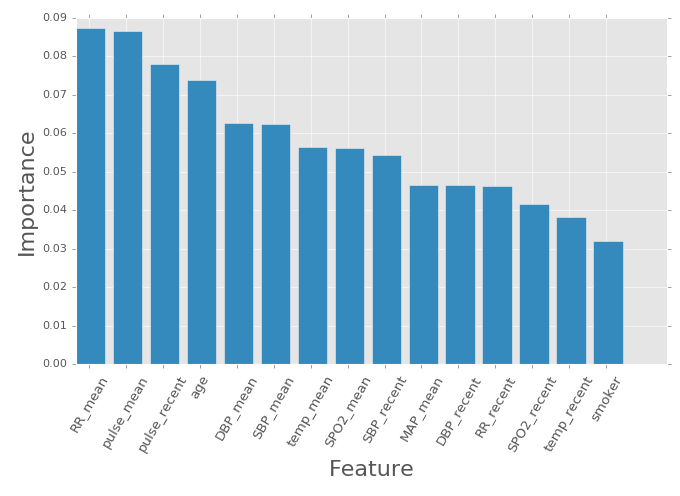

In [31]:
plt.figure()
make_feature_importance_plot(gbcRankedFeatures, 15)
plt.tight_layout()

<IPython.core.display.Javascript object>


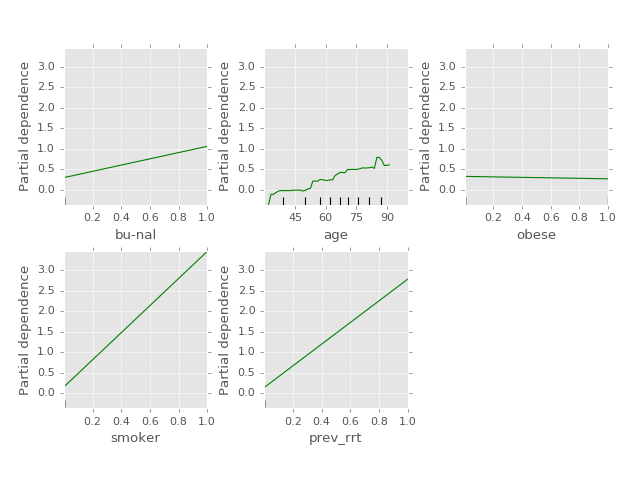

In [23]:
fig, axs = plot_partial_dependence(gbcModel, X_train, range(1, 6, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


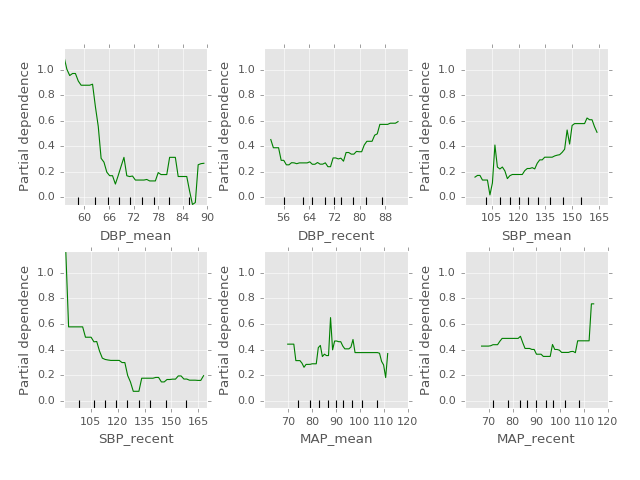

In [25]:
fig, axs = plot_partial_dependence(gbcModel, X_train, range(6, 12, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


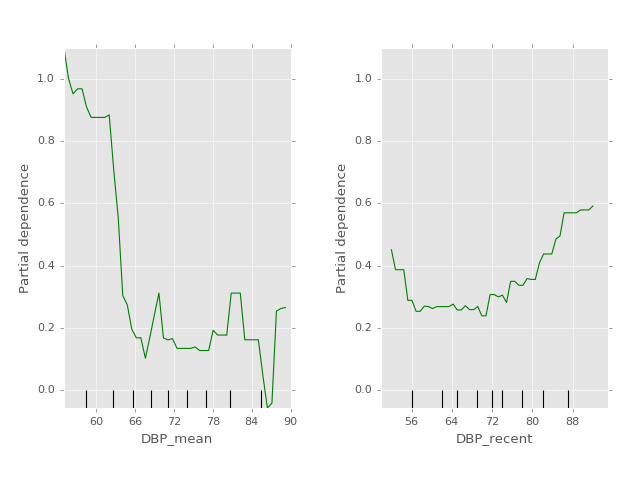

In [34]:
fig, axs = plot_partial_dependence(gbcModel, X_train, range(6, 8, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


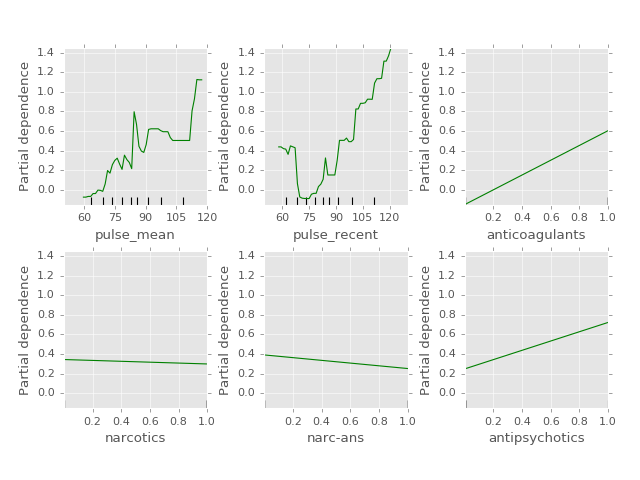

In [26]:
fig, axs = plot_partial_dependence(gbcModel, X_train, range(18, 24, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


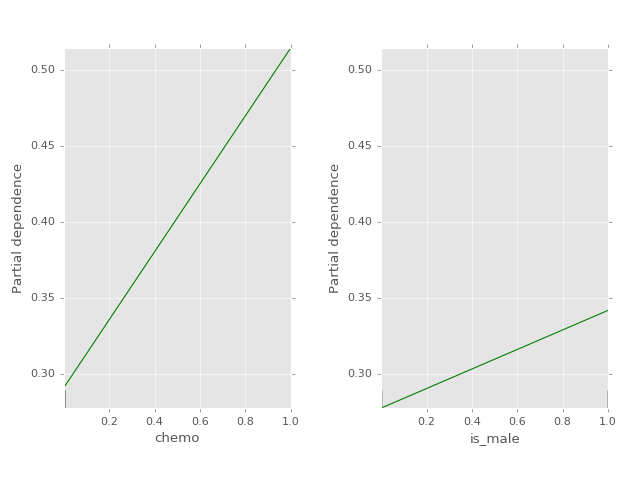

In [27]:
fig, axs = plot_partial_dependence(gbcModel, X_train, range(24, 26, 1), feature_names=X.columns.get_values(), n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

## Use 3-D plot to investigate feature interactions for weak partial dependence plots... (weak effect may be masked by stronger interaction with other features)

In [428]:
names

Index([u'on_iv', u'bu-nal', u'age', u'obese', u'smoker', u'prev_rrt',
       u'DBP_mean', u'DBP_recent', u'SBP_mean', u'SBP_recent', u'MAP_mean',
       u'MAP_recent', u'temp_mean', u'temp_recent', u'SPO2_mean',
       u'SPO2_recent', u'RR_mean', u'RR_recent', u'pulse_mean',
       u'pulse_recent', u'anticoagulants', u'narcotics', u'narc-ans',
       u'antipsychotics', u'chemo', u'is_male'],
      dtype='object')

In [28]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


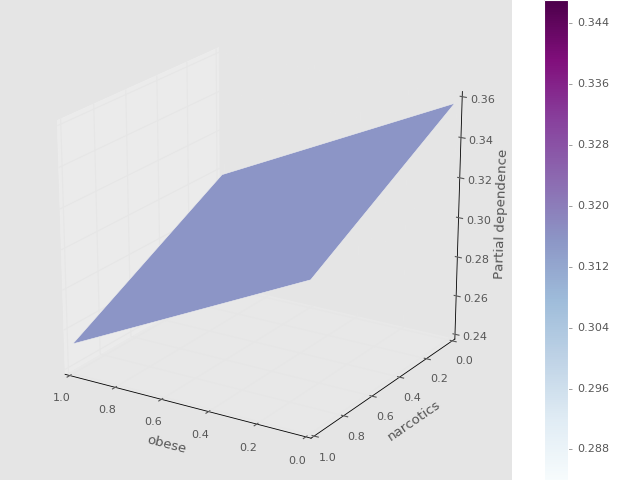

In [29]:
# not quite getting the results I was expecting. Needs work.
fig = plt.figure()

names = X_train.columns

target_feature = (3, 21)
pdp, (x_axis, y_axis) = partial_dependence(gbcModel, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('')
plt.subplots_adjust(top=0.9)

plt.show()